In [1]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pyro.nn import PyroModule, PyroSample
from torch import nn
import torch
import pyro.distributions as dist
from chirho.observational.handlers import condition
from chirho.observational.handlers.predictive import PredictiveModel
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
import functools
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator, one_step_corrected_estimator 
from typing import Callable

smoke_test = "CI" in os.environ

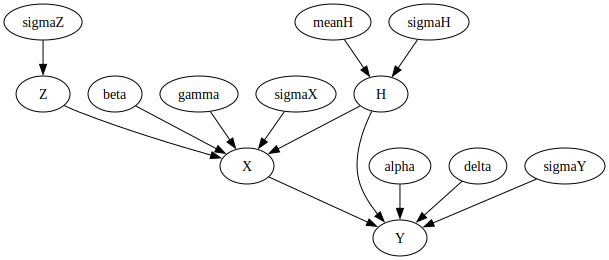

In [2]:
class BayesianLinearGaussianSCM(PyroModule):
    def __init__(self):
        super().__init__()

    @PyroSample
    def alpha(self):
        return dist.Normal(0,10)

    @PyroSample
    def beta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def gamma(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def delta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def sigmaZ(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaH(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaX(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaY(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def meanH(self):
        return dist.Normal(0,2)
    
    def forward(self):
        Z = pyro.sample('Z',dist.Normal(0,self.sigmaZ))
        H = pyro.sample('H',dist.Normal(self.meanH, self.sigmaH))
        X = pyro.sample('X',dist.Normal(self.beta * Z + self.gamma * H, self.sigmaX))
        Y = pyro.sample('Y',dist.Normal(self.alpha * X + self.delta * H, self.sigmaY))
        return X,Y

pyro.render_model(BayesianLinearGaussianSCM())


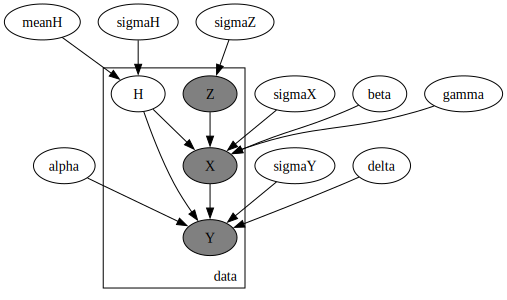

In [3]:
class ObservedBayesianLinearGaussianSCM(BayesianLinearGaussianSCM):
    def __init__(self):
        super().__init__()

    def forward(self, X : torch.tensor, Y: torch.tensor,Z : torch.tensor):
        self.alpha, self.beta, self.gamma, self.delta, self.sigmaZ, self.sigmaH, self.sigmaX, self.sigmaY, self.meanH
        with condition(data={'Z': Z, 'X' : X, 'Y': Y}):
            with pyro.plate("data", Z.shape[0], dim=-1):
                return super().forward()
            

pyro.render_model(lambda : ObservedBayesianLinearGaussianSCM()(Z=torch.rand(10), X=torch.rand(10), Y=torch.rand(10)))

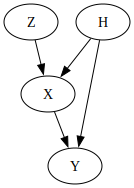

In [4]:
class GroundTruthModel(BayesianLinearGaussianSCM):
    def __init__(self, alpha, beta, gamma, delta, sigmaZ, sigmaH, sigmaX, sigmaY, meanH):
        super().__init__()
        self._alpha = alpha
        self._beta = beta
        self._gamma = gamma
        self._delta = delta
        self._sigmaZ = sigmaZ
        self._sigmaH = sigmaH
        self._sigmaX = sigmaX
        self._sigmaY = sigmaY
        self._meanH = meanH


    @property
    def alpha(self):
        return self._alpha
    
    @property
    def beta(self):
        return self._beta
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def delta(self):
        return self._delta
    
    @property
    def sigmaZ(self):
        return self._sigmaZ
    
    @property
    def sigmaH(self):
        return self._sigmaH
    
    @property
    def sigmaX(self):
        return self._sigmaX
    
    @property
    def sigmaY(self):
        return self._sigmaY
    
    @property
    def meanH(self):
        return self._meanH
    

true_alpha, true_beta, true_gamma, true_delta = torch.tensor(1.5), torch.tensor(2.0), torch.tensor(2.0), torch.tensor(-10.5)
true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY = torch.tensor(1.0), torch.tensor(1.8), torch.tensor(1.0), torch.tensor(1.0)
true_meanH = torch.tensor(1.0)

num_samples = 50000

gt_model = GroundTruthModel(true_alpha, true_beta, true_gamma, true_delta, true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY, true_meanH)

# sample from the model
with pyro.plate('samples', num_samples):
    tr=pyro.poutine.trace(gt_model).get_trace()

x_obs,y_obs,z_obs=[tr.nodes[name]['value'] for name in ['X','Y','Z']]

pyro.render_model(gt_model)


Sanity check: the ATE on the ground truth model should give the alpha coefficient

In [9]:
with MultiWorldCounterfactual(), do(actions=dict(X=(0.,1.))), pyro.plate('samples', num_samples):
    x_all,y_all = gt_model()
    y_cf_1 = gather(y_all, IndexSet(X={2}))
    y_cf_0 = gather(y_all, IndexSet(X={1}))
    ate = (y_cf_1 - y_cf_0).mean()
    print(f'ate_direct={ate}')

# now the two-stage approach
with MultiWorldCounterfactual(), do(actions=dict(Z=(0.,1.))), pyro.plate('samples', num_samples):
    x_all,y_all = gt_model()
    y_cf_1 = gather(y_all, IndexSet(Z={2}))
    y_cf_0 = gather(y_all, IndexSet(Z={1}))

    x_cf_1 = gather(x_all, IndexSet(Z={2}))
    x_cf_0 = gather(x_all, IndexSet(Z={1}))

    xz = (x_cf_1 - x_cf_0).mean()
    yz = (y_cf_1 - y_cf_0).mean()

    ate = yz / xz
    print(f'xz = {xz}, yz = {yz}, ate_2sls = {ate}')

ate_direct=1.4925199747085571
xz = 2.003667116165161, yz = 3.005685567855835, ate_2sls = 1.5000922679901123


In [5]:
num_iterations = 15000 if not smoke_test else 10

pyro.clear_param_store()

obs_model = ObservedBayesianLinearGaussianSCM()
obs_guide = AutoNormal(obs_model)

svi = SVI(obs_model, obs_guide, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X=x_obs,Y=y_obs,Z=z_obs)
    if (j + 1) % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss))

[iteration 1000] loss: 374479.3325
[iteration 2000] loss: 368886.4256
[iteration 3000] loss: 366741.4899
[iteration 4000] loss: 365578.4287
[iteration 5000] loss: 364436.3583
[iteration 6000] loss: 363570.7944
[iteration 7000] loss: 363048.0925
[iteration 8000] loss: 362492.1278
[iteration 9000] loss: 362203.7008
[iteration 10000] loss: 362058.0909
[iteration 11000] loss: 361937.6444
[iteration 12000] loss: 361864.4256
[iteration 13000] loss: 361776.2798
[iteration 14000] loss: 361678.1991
[iteration 15000] loss: 361766.7952


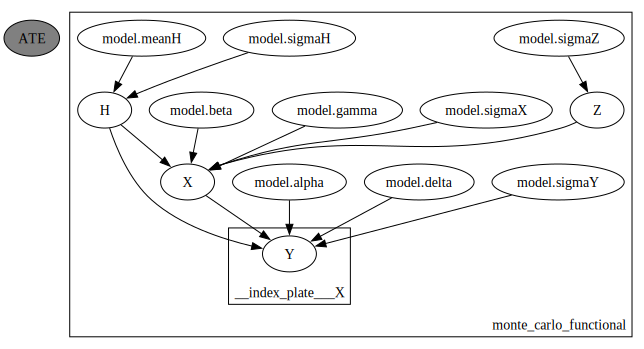

In [6]:
class LinearInstrumentalATE2(PyroModule):
    def __init__(self, causal_model : Callable, num_monte_carlo : int = 1000):
        super().__init__()
        self.model = causal_model
        self.num_monte_carlo = num_monte_carlo

    def forward(self, *args, **kwargs):
        with MultiWorldCounterfactual():
            with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
                with do(actions=dict(X=(torch.tensor(0.),torch.tensor(1.)))):
                    _, y_all = self.model(*args, **kwargs)
                y_cf_1 = gather(y_all, IndexSet(X={2}), event_dim=0)
                y_cf_0 = gather(y_all, IndexSet(X={1}), event_dim=0)
        
        ate = (y_cf_1 - y_cf_0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
        return pyro.deterministic("ATE", ate)
        
pyro.render_model(LinearInstrumentalATE2(BayesianLinearGaussianSCM()))

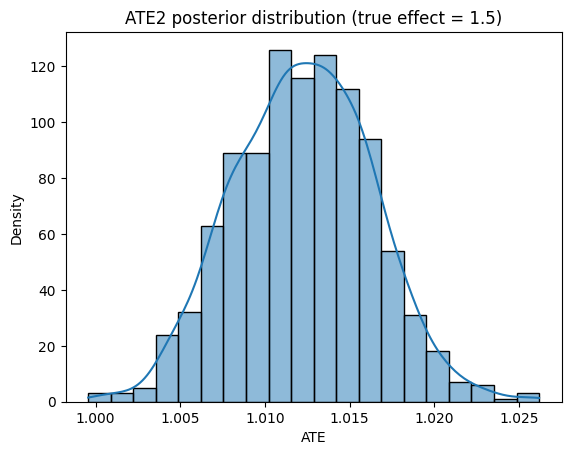

In [8]:
ates_predicted2 = Predictive(LinearInstrumentalATE2(PredictiveModel(BayesianLinearGaussianSCM(),obs_guide), num_monte_carlo=10),num_samples=1000)()["ATE"].squeeze()

sns.histplot(ates_predicted2, bins=20, kde=True)
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE2 posterior distribution (true effect = {true_alpha.item()})')
plt.show()

The standard causal effect of $X$ on $Y$ cannot be estimated correctly because the parameters of the model were not properly recovered by SVI.

Let's try MC-EIF:

In [7]:
dataset = dict(X=x_obs, Y=y_obs, Z=z_obs)

[(k,dataset[k].shape) for k in dataset.keys()]

functional = functools.partial(LinearInstrumentalATE2, num_monte_carlo = 100)
ate_plug_in = functional(
    PredictiveModel(BayesianLinearGaussianSCM(), obs_guide)
)()

ate_plug_in

tensor(1.0105, grad_fn=<ExpandBackward0>)

In [10]:
functional2 = functools.partial(LinearInstrumentalATE2, num_monte_carlo = 100)

with MonteCarloInfluenceEstimator(num_samples_outer=10, num_samples_inner=1):
    automated_monte_carlo_correction = one_step_corrected_estimator(functional2, dataset)(
        PredictiveModel(BayesianLinearGaussianSCM(),obs_guide)
    )()

/Users/dima/git/chirho/chirho/robust/handlers/estimators.py:72: UserWarning: Calling influence_fn with torch.grad enabled can lead to memory leaks. Please use torch.no_grad() to avoid this issue. See example in the docstring.
  warnings.warn(


AttributeError: '_Context' object has no attribute 'param_state'